## Suicidal and Self-Injurious Incidents Prediction

#### This script runs Machine Learning models on structured data alone and on structured data alongside predicted probabiliites from the Transformer Encoder model on ntoes data alone, with and without under-sampling.

### Load Data

In [66]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

# For handeling dataframes
import pandas as pd
import numpy as np
import gzip
import re                                  # For regular expression operations
import string                              # For string operations
import math
import time
import random
import gc



# For building neural netwrok models
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam

# For model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [67]:
# Load the data
data = pd.read_csv("Z:/rscripts/users/interns/hlu/data/cleaned_model_str_notes_Alex.csv")
data.shape

(87975, 18)

In [68]:
data.columns

Index(['Unnamed: 0', 'InmateID', 'BookingNumber', 'DateOfBirth', 'Sex', 'Race',
       'MaritalStatus', 'BookingDate', 'LastUpdateDateTime', 'ReleaseDate',
       'soap_sub', 'soap_obj', 'soap_ass', 'soap_plan', 'quick_notes', 'event',
       'age', 'AB109'],
      dtype='object')

In [75]:
# Delete the useless column
structured = data[['Sex', 'Race', 'MaritalStatus', 'age', 'AB109', 'event']]

In [76]:
structured['AB109'] = [1 if x=="Ture" else 0 for x in structured['AB109']]

In [77]:
def age_group(x):
    if x < 25:
        group = 'lt_25'
    elif x < 35:
        group = '25-35'
    elif x < 45:
        group = '35-45'
    elif x < 55:
        group = '45-55'
    else:
        group = 'gt_55'
    
    return(group)

In [78]:
structured['age_cat'] = [age_group(x) for x in structured['age']] # group age

In [136]:
X = pd.get_dummies(structured[['Sex','Race','MaritalStatus','age_cat','AB109']])
y = structured['event']

In [81]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    pred = (y_pred > 0.5).astype("int32")
    
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = (2*precision*recall)/(precision + recall)
    acc = (tp+tn)/(tn+fp+fn+tp)
    
    auc_roc = round(roc_auc_score(y, y_pred),4)
    pre, rec, thresholds = precision_recall_curve(y, y_pred)
    auc_pr = round(auc(rec, pre),4)
    return(auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp)

### Load indicies and predictions from notes

In [82]:
# Load the 10 training and test sets
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv')

pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True)

In [84]:
pd_train_idx_10.head(2)

,0,1,2,3,4,5,6,7,8,9
0,21382,67168,44241,32895,50243,16907,59817,84579,42076,26331
1,9973,21571,52839,8788,67684,29912,11357,46855,26480,55932


In [85]:
# Load predictions from text data

pd_pred_train_10 = pd.read_csv("other2\pd_pred_train_10.csv")
pd_pred_test_10 = pd.read_csv("other2\pd_pred_test_10.csv")

pd_pred_train_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_pred_test_10.drop('Unnamed: 0', axis=1, inplace=True)

In [87]:
sum(pd_pred_train_10.iloc[:,4].isna())

0

## Run models

In [88]:
model_lg = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=5, l1_ratio =0)
model_rf = RandomForestClassifier(min_samples_split = 5, criterion = 'entropy', max_depth = 10,max_features='auto')
model_xgboost = XGBClassifier(verbosity = 0, booster = 'gblinear', max_depth = 4, n_estimators = 200)
model_knn = KNeighborsClassifier(n_neighbors = 5, weights= 'distance')
model_svm = SVC(kernel="rbf", C=0.1, gamma=0.001, probability=True)

models = [model_lg, model_rf, model_xgboost, model_knn, model_svm]
model_names = ['model_lg', 'model_rf', 'model_xgboost', 'model_knn', 'model_svm']

In [89]:
# Take the log of the predicted probabilities to avoid near 0 values
def log_data(x):
    if np.log(x) < -100:
        log_x = -100
    else:
        log_x = np.log(x)
    
    return(log_x)

## No Undersampling Without Predictions from Notes

In [90]:
with open('structured_textpred/structured_only.csv','a') as fd:
    fd.write(f'Structured data only + no understampling + Save Predictions for Ensemble\n')


pred_train_10 = []
pred_test_10 = []
    
j = 0 # to keep track of the iteration number    
for ii in range(10):
    time_s = time.time()
    
    # Train and test data
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    j += 1
    iteration = "iter" + str(j)
    print(iteration, '....')
    x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start
        
        
         # Save predictions
        pred_train = model.predict_proba(x_train)    
        pred_train_10.append(pred_train[:,1])
        np.save('other/predictions_ML/' + 'pred_train_pct28_noText' + str(model_names[jj]), pred_train)
        
        pred_test = model.predict_proba(x_test)
        pred_test_10.append(pred_test[:,1])
        np.save('other/predictions_ML/' + 'pred_train_pct28_noText' + str(model_names[jj]), pred_test)

        with open('structured_textpred/structured_only.csv','a') as fd:
            fd.write(f'{model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')

# Save predicted probabilities for ensemble models
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_pred_train_10.to_csv("other2\pd_pred_train_10_ML_noText_pct28.csv") # save predictions from machine learning models
pd_pred_test_10.to_csv("other2\pd_pred_test_10_ML_noText_pct28.csv") # save predictions from machine learning models

iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....
iter10 ....


## Undersampling without Predictions from Notes

In [95]:
# Undersampling to pct prevalence
pct = 0.1

# Load the 10 undersampled training sets
pd_train_idx_10pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')

pred_train_10 = []
pred_test_10 = []

with open('structured_textpred/structured_only.csv','a') as fd:
    fd.write(f'Undersampling Structured Data only to pct_{pct} prevalence + Save predictions for Ensemble Learner\n')
    
    
for ii in range(10):
    time_s = time.time()
    
    # Train and test data
    train_index = pd_train_idx_10pct.iloc[:, ii].values # Undersampled training sets
    test_index = pd_test_idx_10.iloc[:, ii].values # Test sets remain the same
    

    iteration = "iter" + str(ii) # to keep track of the iteration number 
    print(iteration, '....')
    x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
        
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_only.csv','a') as fd:
            fd.write(f'{model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')

        # Save predictions
        pred_train = model.predict_proba(x_train)    
        pred_train_10.append(pred_train[:,1])
        np.save('other/predictions_ML/' + f'pred_train_pct{pct}_noText' + str(model_names[jj]), pred_train)
        
        pred_test = model.predict_proba(x_test)
        pred_test_10.append(pred_test[:,1])
        np.save(f'other/predictions_ML/' + f'pred_train_pct{pct}_noText' + str(model_names[jj]), pred_test)
        
# Save predicted probabilities for ensemble models
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_pred_train_10.to_csv(f"other2\pd_pred_train_10_ML_noText_pct{pct}.csv") # save predictions from machine learning models
pd_pred_test_10.to_csv(f"other2\pd_pred_test_10_ML_noText_pct{pct}.csv") # save predictions from machine learning models

iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


## No undersampling + Predictions from Notes

In [104]:
np.asarray(x_train['pred_text']).reshape(-1,1)

array([[-33.38693239],
       [-28.42784878],
       [-30.98754316],
       ...,
       [-22.89752773],
       [-33.81137466],
       [-31.31847383]])

In [105]:
# Load predictions from text data

pd_pred_train_10 = pd.read_csv("other2\pd_pred_train_10.csv")
pd_pred_test_10 = pd.read_csv("other2\pd_pred_test_10.csv")

pd_pred_train_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_pred_test_10.drop('Unnamed: 0', axis=1, inplace=True)

with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Structured data + predictions from text data + no understampling + save predictions for ensemble\n')
    

pred_train_10 = []
pred_test_10 = []


j = 0 # to keep track of the iteration number    
for ii in range(10):
    time_s = time.time()
    
    # Train and test data
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    j += 1
    iteration = "iter" + str(j)
    print(iteration, '....')
    x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    # Predictions from text data (apply log on predictions from text to avoid numbers too small)
    x_train['pred_text'] = [log_data(e) for e in pd_pred_train_10.iloc[:, ii]]
    x_test['pred_text'] = [log_data(e) for e in pd_pred_test_10.iloc[:, ii]]
    
    # Scale pred_text
    scaler = StandardScaler()
    scaler.fit(np.asarray(x_train['pred_text']).reshape(-1,1))
    x_train['pred_text'] = scaler.transform(np.asarray(x_train['pred_text']).reshape(-1,1))
    x_test['pred_text'] = scaler.transform(np.asarray(x_test['pred_text']).reshape(-1,1))
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start
        
        
        # Save predictions
        pred_train = model.predict_proba(x_train)    
        pred_train_10.append(pred_train[:,1])
        np.save('other/predictions_ML/' + 'pred_train_Text_pct28' + str(model_names[jj]), pred_train)
        
        pred_test = model.predict_proba(x_test)
        pred_test_10.append(pred_test[:,1])
        np.save('other/predictions_ML/' + 'pred_test_Text_pct28' + str(model_names[jj]), pred_test)

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'{model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')

# Save predicted probabilities for ensemble models
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_pred_train_10.to_csv("other2\pd_pred_train_10_ML_Text_pct28.csv") # save predictions from machine learning models
pd_pred_test_10.to_csv("other2\pd_pred_test_10_ML_Text_pct28.csv") # save predictions from machine learning models

iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....
iter10 ....


## Undersampling + Predictions from Notes

In [112]:
# Undersampling to pct prevalence
pct = 0.5

# Load the indices of the 10 undersampled training sets
pd_train_idx_pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

# Load the predictions 
pd_train_pred_pct = pd.read_csv(f'other2/pd_pred_train_10_pct_{pct}.csv')
pd_test_pred_pct = pd.read_csv(f'other2/pd_pred_test_10_pct_{pct}.csv')


pd_train_idx_pct.drop('Unnamed: 0', axis=1, inplace = True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_train_pred_pct.drop('Unnamed: 0', axis=1, inplace = True)
pd_test_pred_pct.drop('Unnamed: 0', axis=1, inplace = True)

pred_train_10 = []
pred_test_10 = []

with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Undersampling with Text Predictions to {pct} prevalence + save predictions for Ensemble Learner\n')


for ii in range(10):
    time_s = time.time()
    
    # Train and test data
    train_index = pd_train_idx_pct.iloc[:, ii].values # Undersampled training sets
    test_index = pd_test_idx_10.iloc[:, ii].values # Test sets remain the same
    
    iteration = "iter" + str(ii) # to keep track of the iteration number    
    print(iteration, '....')
    x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    # Predictions from text data (apply log on predictions from text to avoid numbers too small)
    x_train['pred_text'] = [log_data(e) for e in pd_train_pred_pct.iloc[:, ii]]
    x_test['pred_text'] = [log_data(e) for e in pd_test_pred_pct.iloc[:, ii]]
    
    # Scale pred_text
    scaler = StandardScaler()
    scaler.fit(np.asarray(x_train['pred_text']).reshape(-1,1))
    x_train['pred_text'] = scaler.transform(np.asarray(x_train['pred_text']).reshape(-1,1))
    x_test['pred_text'] = scaler.transform(np.asarray(x_test['pred_text']).reshape(-1,1))

    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'{model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')

        # Save predictions
        pred_train = model.predict_proba(x_train)    
        pred_train_10.append(pred_train[:,1])
        np.save('other/predictions_ML/' + f'pred_train_pct{pct}_Text' + str(model_names[jj]), pred_train)
        
        pred_test = model.predict_proba(x_test)
        pred_test_10.append(pred_test[:,1])
        np.save(f'other/predictions_ML/' + f'pred_train_pct{pct}_Text' + str(model_names[jj]), pred_test)
        
# Save predicfted probabilities for ensemble models
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_pred_train_10.to_csv(f"other2\pd_pred_train_10_ML_Text_pct{pct}.csv") # save predictions from machine learning models
pd_pred_test_10.to_csv(f"other2\pd_pred_test_10_ML_Text_pct{pct}.csv") # save predictions from machine learning models

iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### No_undersampling + Predictions from Notes for Ensemble Learner

In [143]:
# Load the indices of the 10 training and test sets
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load predictions from Machine Learning Models with text data (No Undersampling)

ML_pred_train_10 = pd.read_csv("other2\pd_pred_train_10_ML_Text_pct28.csv")
ML_pred_test_10 = pd.read_csv("other2\pd_pred_test_10_ML_Text_pct28.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)

with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'No_undersampling + Text Prediction: Ensemble Learner model performance + remove SVM + multiple_models\n')

for ii in range(10):
    
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Undersampling + Predictions from Notes for Ensemble Learner

In [148]:
pct = 0.5

# Load the indices of the 10 undersampled sets
pd_train_idx_pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_pct.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_Text_pct{pct}.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_Text_pct{pct}.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Undersample to prevalence {pct} + Text Prediction + Ensemble Learner + remove SVM + multiple models\n')

for ii in range(10):
    
    train_index = pd_train_idx_pct.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### No Under-sampling + No Predictions from Notes + Ensemble Learner:

In [149]:
# Load the indices of the 10 training and test sets
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_noText_pct28.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_noText_pct28.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'No Undersampling + No Text Prediction + Ensemble Learner + remove SVM + multiple models\n')

for ii in range(10):
    
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Under-sampling + No Predictions from Notes + Ensemble Learner:

In [154]:
pct = 0.5

# Load the indices of the 10 undersampled sets
pd_train_idx_pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_pct.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_noText_pct{pct}.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_noText_pct{pct}.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Undersample to prevalence {pct} + No Text Prediction: Ensemble Learner + remove SVM + multiple models\n')

for ii in range(10):
    
    train_index = pd_train_idx_pct.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
     # Run models
    for jj in range(len(models)):
        model_time_start = time.time()
        model = models[jj]
        model.fit(x_train, y_train)
         # Collect and log evaluation metrics
        auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
        model_time = time.time() - model_time_start

        with open('structured_textpred/structured_textpred.csv','a') as fd:
            fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Ensemble Logistic with two-way Interactions (Structured Only + No Under-sampling)

In [155]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special


In [170]:
# Load the indices of the 10 training and test sets
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_noText_pct28.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_noText_pct28.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'No Undersampling + No Text Prediction + Ensemble Learner + remove SVM + 2-way Interactions+LASSO\n')

for ii in range(10):
    
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
    
    # Scale predicted probabilites from Machine Learning models
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Two-way interaction
    poly = PolynomialFeatures(interaction_only=True) # Only include interactions, no squares
    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)
    
    
     # Run models

    model_time_start = time.time()
#     model = LogisticRegression()
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=5, l1_ratio =0)
    model.fit(x_train, y_train)
     # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
    model_time = time.time() - model_time_start

    with open('structured_textpred/structured_textpred.csv','a') as fd:
        fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Ensemble Learner with 2-way Interaction (Stuctured Only + Under-sampling)

In [175]:
pct = 0.5

# Load the indices of the 10 undersampled sets
pd_train_idx_pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_pct.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_noText_pct{pct}.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_noText_pct{pct}.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Undersample to {pct} + No Text Prediction + Ensemble Learner + remove SVM + Interactions + LASSO\n')

for ii in range(10):
    
    train_index = pd_train_idx_pct.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
       
    # Scale predicted probabilites from Machine Learning models
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Two-way interaction
    poly = PolynomialFeatures(interaction_only=True) # Only include interactions, no squares
    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)
        
     # Run models
    model_time_start = time.time()
#     model = LogisticRegression()
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=5, l1_ratio =0)
    model.fit(x_train, y_train)
     # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
    model_time = time.time() - model_time_start

    with open('structured_textpred/structured_textpred.csv','a') as fd:
        fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Ensemble Learner with 2-way Interactions (Structured+Pred + No-undersampling)

In [176]:
# Load the indices of the 10 training and test sets
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load predictions from Machine Learning Models with text data (No Undersampling)

ML_pred_train_10 = pd.read_csv("other2\pd_pred_train_10_ML_Text_pct28.csv")
ML_pred_test_10 = pd.read_csv("other2\pd_pred_test_10_ML_Text_pct28.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)

with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'No_undersampling + Text Prediction: Ensemble Learner + remove SVM + Interactions + LASSO\n')

for ii in range(10):
    
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
    
    # Scale predicted probabilites from Machine Learning models
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Two-way interaction
    poly = PolynomialFeatures(interaction_only=True) # Only include interactions, no squares
    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)
        
     # Run models
    model_time_start = time.time()
#     model = LogisticRegression()
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=5, l1_ratio =0)
    model.fit(x_train, y_train)
    
     # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
    model_time = time.time() - model_time_start

    with open('structured_textpred/structured_textpred.csv','a') as fd:
        fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Ensemble Learner with 2-way Interactions (Structured + Pred + Under-sampling)

In [181]:
pct = 0.5

# Load the indices of the 10 undersampled sets
pd_train_idx_pct = pd.read_csv(f'other3/pd_under_idx_10_pct_{pct}.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv') # Test sets remain the same

pd_train_idx_pct.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True) 

# Load the predictions from the 5 models
ML_pred_train_10 = pd.read_csv(f"other2\pd_pred_train_10_ML_Text_pct{pct}.csv")
ML_pred_test_10 = pd.read_csv(f"other2\pd_pred_test_10_ML_Text_pct{pct}.csv")

ML_pred_train_10.drop('Unnamed: 0', axis=1, inplace = True)
ML_pred_test_10.drop('Unnamed: 0', axis=1, inplace = True)


with open('structured_textpred/structured_textpred.csv','a') as fd:
    fd.write(f'Undersample {pct} + Text Prediction + Ensemble Learner + remove SVM + interactions + LASSO\n')

for ii in range(10):
    
    train_index = pd_train_idx_pct.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    iteration = "iter" + str(ii)
    print(iteration, '....')
    y_train, y_test = y[train_index], y[test_index]
    
    # Take the predictions from the 5 models
    x_train = ML_pred_train_10.iloc[:,ii*5+0:ii*5+4]   
    x_test = ML_pred_test_10.iloc[:,ii*5+0:ii*5+4]
    
    # Scale predicted probabilites from Machine Learning models
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Two-way interaction
    poly = PolynomialFeatures(interaction_only=True) # Only include interactions, no squares
    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)
        
     # Run models
    model_time_start = time.time()
#     model = LogisticRegression()
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=5, l1_ratio =0)
    model.fit(x_train, y_train)
    
     # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(model, x_test, y_test)
    model_time = time.time() - model_time_start

    with open('structured_textpred/structured_textpred.csv','a') as fd:
        fd.write(f'Ensemble, {model_names[jj]},{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp},{model_time}\n')


iter0 ....
iter1 ....
iter2 ....
iter3 ....
iter4 ....
iter5 ....
iter6 ....
iter7 ....
iter8 ....
iter9 ....


### Logistic Regression

In [77]:
lg = GridSearchCV(cv=5,
             estimator = LogisticRegression(),
             param_grid={"penalty": ["l1", 'l2'], 
                         "solver": ['liblinear', 'sag', 'saga'],
                         "C": [0.1, 1, 5, 10],
                         "l1_ratio": [0, 0.3, 0.5, 0.7, 1]
                        })
lg.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 5, 10],
                         'l1_ratio': [0, 0.3, 0.5, 0.7, 1],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'saga']})

In [78]:
print('Best Parameters:\n', lg.best_params_)

Best Parameters:
 {'C': 5, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear'}


### Lasso 

In [58]:
LogisticRegression?

In [45]:
from sklearn.linear_model import Lasso

In [55]:
lg_lasso = GridSearchCV(cv=5,
             estimator = Lasso(),
             param_grid={"alpha": [0.5, 1, 5, 10], "fit_intercept": [True, False]})
lg_lasso.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.5, 1, 5, 10],
                         'fit_intercept': [True, False]})

In [56]:
evaluate(lg_lasso, x_test, y_test)

(0.5622, 0.0316, 0.9733827493261455, nan, 0.0, 1.0, nan)

In [57]:
print('Best Parameters:\n', lg_lasso.best_params_)

Best Parameters:
 {'alpha': 10, 'fit_intercept': True}


### Random Forest

In [24]:
from sklearn.model_selection import GridSearchCV

In [99]:
# Use Gridsearch to find the best parameters for the Random Forest model:
from sklearn.ensemble import RandomForestClassifier

rf = GridSearchCV(cv=5,
             estimator = RandomForestClassifier(min_samples_split = 5),
             param_grid={"criterion": ["entropy", 'gini'], "max_depth": [5, 10, 20], 'max_features': ['auto', 'sqrt']})
rf.fit(x_train, y_train)

print('Best Parameters:\n', rf.best_params_)

Best Parameters:
 {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}


In [ ]:
# 'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [300]:
pred = rf.predict(x_test)

In [32]:
confusion_matrix(y_test, pred)

array([[2883,    6],
       [  56,   23]], dtype=int64)

In [92]:
evaluate(rf, x_test, y_test)

(0.4993,
 0.0014,
 0.9957564505740159,
 0.0,
 0.0,
 0.99859411809408,
 nan,
 26281,
 37,
 75,
 0)

### KNN Model

In [103]:
# Use Gridsearch to find the best parameters for the KNN model:
from sklearn.neighbors import KNeighborsClassifier 

knn = GridSearchCV(cv=5,
             estimator = KNeighborsClassifier(),
             param_grid={"weights": ["distance", 'uniform'], "n_neighbors": [5, 7, 9]})
knn.fit(x_train, y_train)
print('Best Parameters:\n', knn.best_params_)

Best Parameters:
 {'n_neighbors': 5, 'weights': 'distance'}


In [104]:
evaluate(knn, x_test, y_test)

(0.4994,
 0.0014,
 0.9960595612473004,
 0.0,
 0.0,
 0.998898092560225,
 nan,
 26289,
 29,
 75,
 0)

### SVM Model

In [15]:
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC

In [106]:
# Use KernelPCA to change the data representation (project the original data to higher dimension)
svm = GridSearchCV(cv=5,
             estimator = SVC(kernel="rbf"),
             param_grid={"C": [0.025, 0.05, 0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001]})

svm.fit(x_train, y_train)
print('Best Parameters:\n', svm.best_params_)

Best Parameters:
 {'C': 0.1, 'gamma': 0.001}


### XGBoost

In [98]:
xgb = GridSearchCV(cv=5,
             estimator = XGBClassifier(verbosity = 0),
             param_grid={"booster": ["gbtree", 'gblinear','dart'], "n_estimators": [200, 300, 500], 'max_depth': [4,6,8]})

xgb.fit(x_train, y_train)
print('Best Parameters:\n', xgb.best_params_)

Best Parameters:
 {'booster': 'gblinear', 'max_depth': 4, 'n_estimators': 200}


In [216]:
print('Accuracy:', round(xgb.score(x_test,y_test),4))
print('Best Parameters:\n', xgb.best_params_)

Accuracy: 0.9828
Best Parameters:
 {'booster': 'gblinear', 'max_depth': 4, 'n_estimators': 100}


In [305]:
evaluate(xgb, x_test, y_test)

(0.7682,
 0.604,
 0.980121293800539,
 0.6515151515151515,
 0.5443037974683544,
 0.9920387677397023,
 0.5931034482758619)

In [270]:
xgb1 = XGBClassifier(booster = 'gblinear', n_estimators = 100)

In [271]:
xgb1.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=-1,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, subsample=None, tree_method=None,
              validate_parameters=1, verbosity=None)

In [272]:
# probabilites from text classification with over- and under- sampling
evaluate(xgb1, x_test, y_test)

(0.6103,
 0.355,
 0.9723719676549866,
 0.46153846153846156,
 0.22784810126582278,
 0.9927310488058152,
 0.3050847457627119)

In [34]:
pred = xgb.predict(x_test)
confusion_matrix(y_test, pred)

array([[2882,    7],
       [  31,   48]], dtype=int64)

In [71]:
from matplotlib import pyplot as plt

In [82]:
xgb1.feature_importances_

array([ 6.9870239e-08, -1.6471268e+00,  7.1076632e-02, -9.8611370e-02,
       -1.1895554e-01, -1.0279215e-01, -9.6887641e-02, -4.6253982e-01,
        1.3155596e-02,  8.6222373e-02, -7.4758483e-03, -9.8040737e-02,
        8.4496766e-02, -2.2484398e-01,  3.3371112e-01, -2.6425568e-02,
       -4.1604817e-01, -3.4293583e-01, -4.6148407e-01,  1.9643235e-03,
        1.0709361e-01,  1.3362673e-01,  3.2788206e-02,  1.6523656e-01,
        1.4395665e-01,  2.3232357e-01,  9.9862449e-02,  3.7412385e-03,
       -4.6925820e-02,  7.5979762e-02,  2.3118609e-01, -5.6969807e-02,
        1.0546323e-02, -8.5148225e-03, -1.2917040e-01,  3.8875345e-02,
        7.2632488e-03,  2.1422903e-01,  1.2915637e-01,  3.3907312e-01,
        2.0678045e-01,  2.6260731e-01,  2.1592718e-01,  1.7424393e-01,
       -4.7747444e-02,  8.2987636e-01,  4.8537832e-02,  3.0805720e-03,
       -1.9678801e-02, -4.1745353e-01,  1.3118086e-02,  4.3843467e-02,
        3.9935850e-02, -1.5605908e-04, -1.7692487e-01,  2.5122157e-01,
      

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

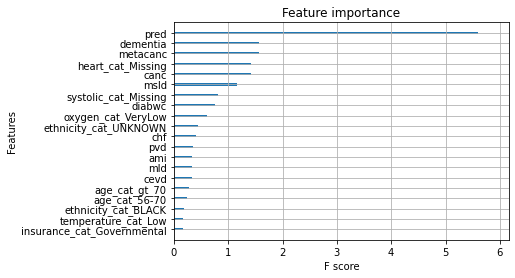

In [150]:
from xgboost import plot_importance
plot_importance(xgb1,max_num_features=20, show_values=False)